In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, make_scorer
import mlflow
import mlflow.sklearn

import json

import shap

## Оценка важности признаков

In [2]:
with open(r"..\\data\run_ids.txt", "rb") as file:
    uri = json.load(file)

In [6]:
data = pd.read_csv(r"..\data/preprocessed_dummy_Data.csv",)
X, y = data.drop(['Churn'], axis=1), data['Churn']

In [3]:
pipeline = mlflow.sklearn.load_model(uri['LR_tuned'])

c:\Users\User\miniconda3\envs\classicalML\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


In [4]:
scl = pipeline.named_steps['scaler']
LR_clf = pipeline.named_steps['logreg']

In [7]:
X_scaled = scl.transform(X)

In [8]:
explainer = shap.LinearExplainer(LR_clf, X_scaled)
shap_values = explainer.shap_values(X_scaled)

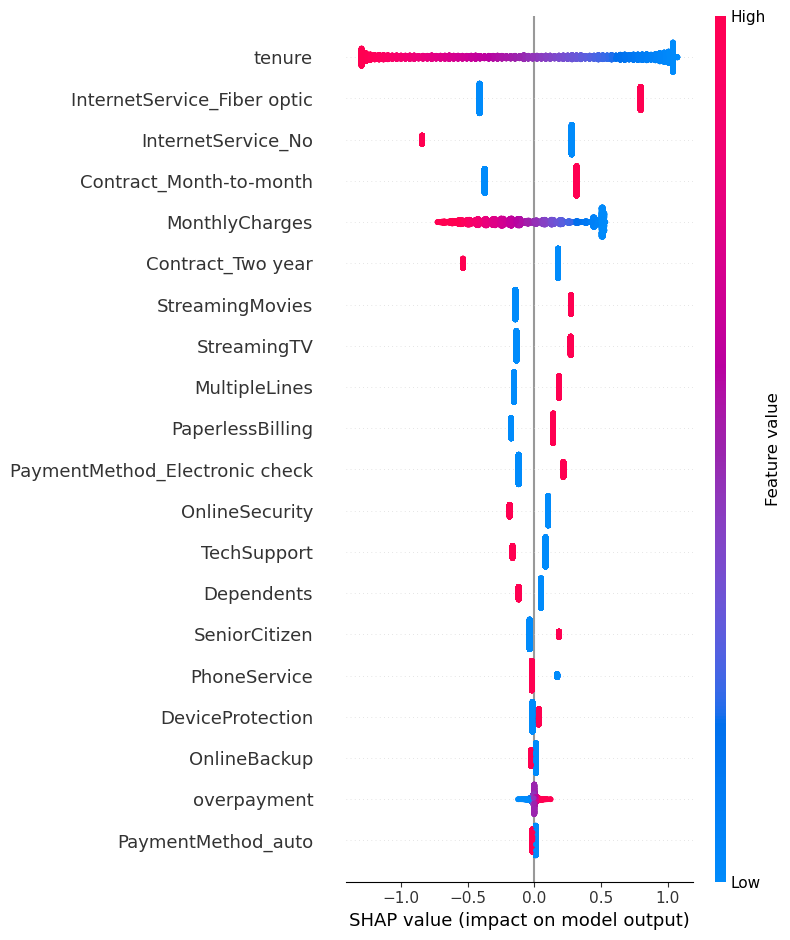

In [9]:
shap.summary_plot(shap_values, X_scaled, feature_names=X.columns)


## Выводы

Каждая точка на графике — один клиент.

 🎨 Как читать график
 Цвет точки = значение признака
- **Красный** → высокое значение признака  
- **Синий** → низкое значение признака  

Положение по оси X = влияние на Churn
- **> 0** → повышает вероятность ухода  
- **< 0** → снижает вероятность ухода  

Чем дальше точка от центра, тем сильнее её влияние.

---
### Топовые признаки и их влияние

- 1. **Tenure (стаж клиента)**
    Самый важный фактор.
    - Красные точки слева → клиенты с низким стажем чаще уходят  
    - Синие точки справа → долгий стаж снижает churn  

👉 **Новые клиенты = основная зона риска.**



- 2. **InternetService_Fiber optic**
    - Красные точки справа → Fiber optic увеличивает churn  
    - Синие слева → DSL/No Internet уменьшают churn  

👉 **Оптоволокно = дорого, высокая чувствительность к цене.**



- 3. **InternetServices (Использование интернет сервисами)**
    - Красные точки слева → клиент не пользуется → клиент доволен и остаётся
    - Синие справа → клиент пользуется сервисами  → иногда может приводить к оттоку 

- 4. **Contract (Периодичность оплаты)**
    заметна тенденция → долгосрочные контракты (Contract_Two_year) приводят к лучшему удержанию клиентов. А Ежемесячная оплата (Contract_Month_to_Month) наоборот один из главных факторов оттока. 

- 5. **MonthlyCharges (ежемесячная оплата)**
    Пародоксально, но слишком маленькая цена являеться фактором оттока клиентов. Возможно стоит пересмотреть дешевые тарифы.

- 6. **SeniorCitisn (Периодичность оплаты)**
    Большая вероятность оттока у пожилых клиентов. 


- 7. **PaymentMethiod (Способ оплаты)**
 ElectronicCheck заметно влияет на отток. Остальные методы оплаты почти не влияют на отток.

---
8. Другие признаки

📌 StreamingMovies, StreamingTV, MultipleLines
Влияние смешанное:
- наличие услуг иногда повышает стоимость → увеличение churn  
- отсутствие услуг может говорить о меньшей вовлечённости  

📌 OnlineSecurity, TechSupport  
Чаще уменьшают churn —  
клиенты, которые пользуются этими услугами, более привязаны к сервису.

 # 🧩 Итоговые бизнес-выводы

## Клиенты с высоким риском ухода:
- новые (низкий tenure)  
- пользуются Fiber optic  
- пользуются дешевыми тарифами
- оплачивают через Electronic check  
- на помесячном контракте  
- пожилые  

## Что может сделать бизнес:
- предложить спец-тарифы новым клиентам  
- снизить нагрузку по дорогим интернет-пакетам  
- стимулировать переход на AutoPay  
- поощрять долгосрочные контракты скидками  
- развивать пакетные услуги (Security / TechSupport)  

---

# 📝 Главный вывод

SHAP показывает, что **основная структура churn в Telco** определяется:
- ценой (`MonthlyCharges`)
- длительностью (`tenure`)
- типом связи (`Fiber optic`)
- типом контракта  
- способом оплаты  

